## Test Flask App
From the another notebook (such as `run_flask.ipynb`), you can run the flask app in a cell and test it from here using python http or `curl` statements.

```python
# run_flask.ipynb
!FLASK_APP=wsgi.py flask run
```

In [1]:
import os

#image file location.
my_image = 'twodogs.jpg'

#route to host
my_route = 'http://localhost:5000'

os.environ["MY_IMAGE"] = my_image
os.environ["MY_ROUTE"] = my_route



In [2]:
!curl "${MY_ROUTE}/status"

{"status":"ok"}


In [3]:
!(echo -n '{"image": "'; base64 "${MY_IMAGE}"; echo '"}') | curl -X POST -H "Content-Type: application/json" -d @- ${MY_ROUTE}/predictions

{"detections":[{"box":{"xMax":0.5364789962768555,"xMin":0.0598805695772171,"yMax":0.9051148891448975,"yMin":0.06668734550476074},"class":"Dog","label":"Dog","score":0.848334789276123},{"box":{"xMax":0.9758182764053345,"xMin":0.5251952409744263,"yMax":0.9843557476997375,"yMin":0.32391244173049927},"class":"Dog","label":"Dog","score":0.7970173954963684},{"box":{"xMax":0.6564328074455261,"xMin":0.5611501336097717,"yMax":0.9914687275886536,"yMin":0.8822833895683289},"class":"Footwear","label":"Footwear","score":0.21159178018569946},{"box":{"xMax":0.2896248698234558,"xMin":0.22168850898742676,"yMax":0.8378414511680603,"yMin":0.7691953778266907},"class":"Footwear","label":"Footwear","score":0.15999531745910645},{"box":{"xMax":0.04073277860879898,"xMin":0.002835853025317192,"yMax":0.5980890989303589,"yMin":0.522162914276123},"class":"Footwear","label":"Footwear","score":0.1487133651971817},{"box":{"xMax":0.2976342439651489,"xMin":0.23572899401187897,"yMax":0.8302286863327026,"yMin":0.77664434

In [4]:
import base64
import requests
from json import dumps

with open(my_image, "rb") as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
content = {"image": encoded_image}
json_data = dumps(content)

headers = {"Content-Type": "application/json"}

response = requests.post(my_route + '/predictions', data=json_data, headers=headers)
result = response.json()

result

{'detections': [{'box': {'xMax': 0.5364789962768555,
    'xMin': 0.0598805695772171,
    'yMax': 0.9051148891448975,
    'yMin': 0.06668734550476074},
   'class': 'Dog',
   'label': 'Dog',
   'score': 0.848334789276123},
  {'box': {'xMax': 0.9758182764053345,
    'xMin': 0.5251952409744263,
    'yMax': 0.9843557476997375,
    'yMin': 0.32391244173049927},
   'class': 'Dog',
   'label': 'Dog',
   'score': 0.7970173954963684},
  {'box': {'xMax': 0.6564328074455261,
    'xMin': 0.5611501336097717,
    'yMax': 0.9914687275886536,
    'yMin': 0.8822833895683289},
   'class': 'Footwear',
   'label': 'Footwear',
   'score': 0.21159178018569946},
  {'box': {'xMax': 0.2896248698234558,
    'xMin': 0.22168850898742676,
    'yMax': 0.8378414511680603,
    'yMin': 0.7691953778266907},
   'class': 'Footwear',
   'label': 'Footwear',
   'score': 0.15999531745910645},
  {'box': {'xMax': 0.04073277860879898,
    'xMin': 0.002835853025317192,
    'yMax': 0.5980890989303589,
    'yMin': 0.52216291427612

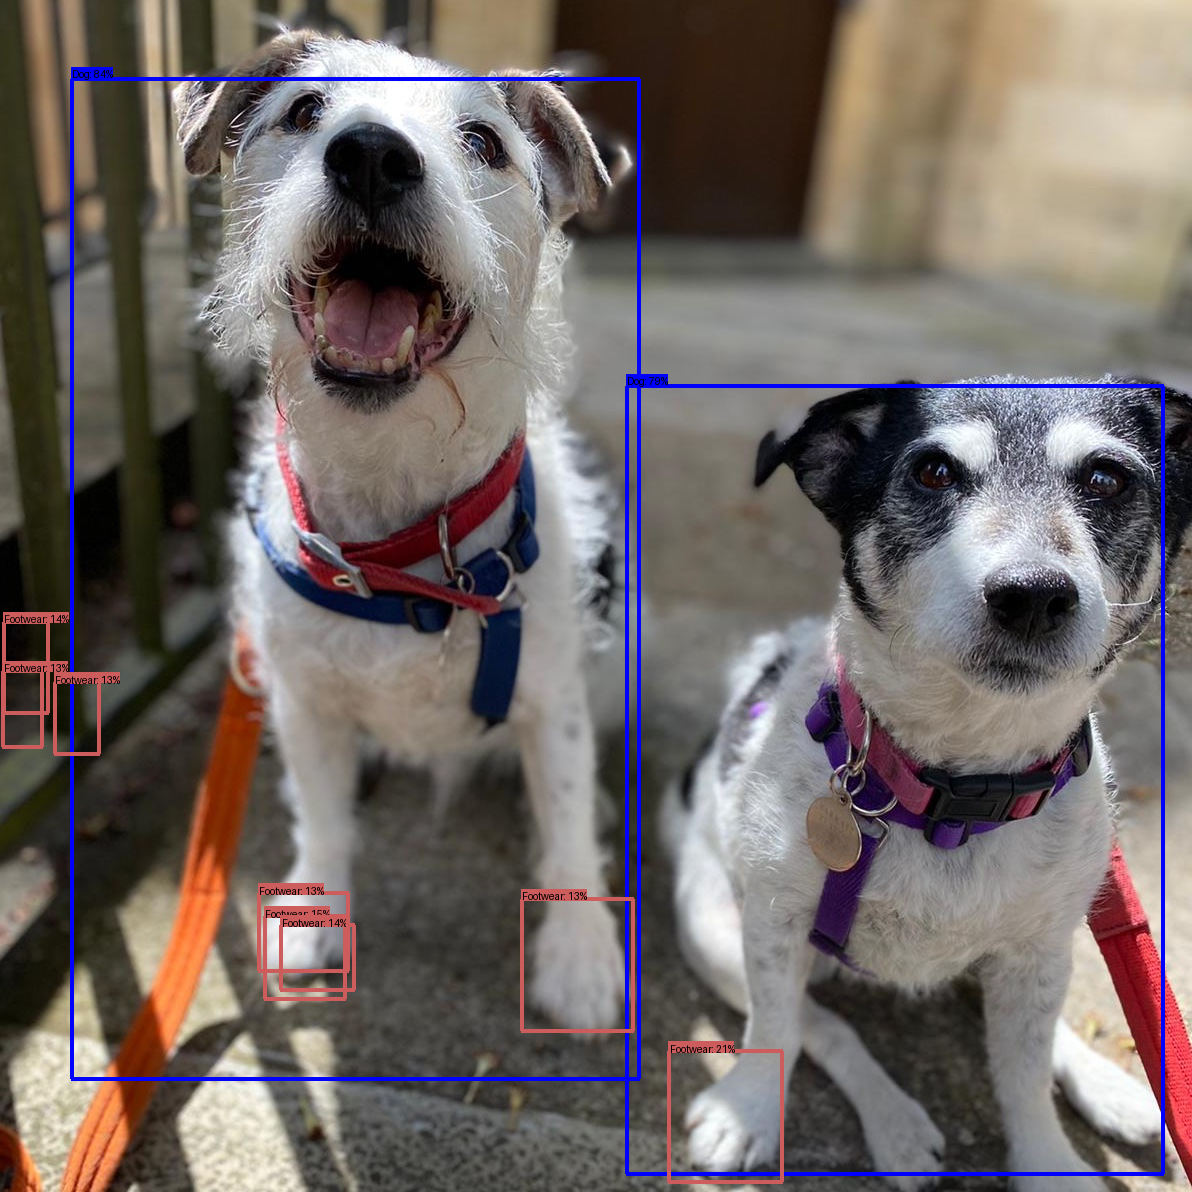

In [6]:
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont


def display_image(image):
    fig = plt.figure(figsize=(10, 10))
    plt.grid(False)
    plt.imshow(image)


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                 ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)

    # Calculate total height of the display strings added to the top of the bounding box
    display_str_heights = [font.getbbox(ds)[3] - font.getbbox(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        bbox = font.getbbox(display_str)
        text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                 display_str,
                 fill="black",
                 font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, detections):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())
    class_colors = {}
    font = ImageFont.load_default()
    image_pil = Image.open(image)

    for d in detections:
        display_str = "{}: {}%".format(d['class'], int(100 * d['score']))
        if not class_colors.get(d['class']):
            class_colors[d['class']] = colors[hash(d['class']) % len(colors)]
        color = class_colors.get(d['class'])
        draw_bounding_box_on_image(
            image_pil,
            d['box']['yMin'],
            d['box']['xMin'],
            d['box']['yMax'],
            d['box']['xMax'],
            color,
            font,
            display_str_list=[display_str])
    return image_pil
    image_pil.show()


draw_boxes(my_image, result['detections'])

Now that our application is running and making predictions as expected, you can go back to the workshop instructions to see how we integrate this into an App with a user interface.